In [ ]:
!pip install psycopg2-binary
!pip install ipython-sql
!pip install pandas
!pip install matplotlib

In [16]:
import configparser
import matplotlib.pyplot as plt
import numpy as np

In [26]:
config = configparser.ConfigParser()
config.read('config/db.cfg')
pg_info = config['POSTGRES']

dbname = pg_info['db']
host = pg_info['host']
user = pg_info['user']
password = pg_info['password']
port = ''
if 'port' in pg_info:
    port = ':' + pg_info['port']

conn_string = 'postgresql://{}:{}@{}{}/{}'.format(user, password, host, port, dbname)

In [27]:
%reload_ext sql

In [28]:
%sql $conn_string

'Connected: postgres@mtatransit'

In [ ]:
%%sql
SELECT station, recorded_date, sum(entry_count) as daily_entry
FROM turnstile_transformed
group by station, recorded_date
order by recorded_date desc
LIMIT 50

In [ ]:
%%sql
SELECT recorded_date, sum(entry_count) as daily_entry
FROM turnstile_transformed
where entry_count < 2048
group by recorded_date
order by recorded_date desc
LIMIT 365

In [106]:
avg_daily_entry_per_year_weekdays_query = """
SELECT 
    extract(year from recorded_date) as year,
    avg(daily_entry) as daily_entry_avg_weekdays
FROM 
(
    SELECT 
        recorded_date, 
        sum(entry_count) as daily_entry
    FROM 
        turnstile_transformed
    where 
        entry_count < 2048
    group by 
        recorded_date
    having 
        extract(isodow from recorded_date)  <> 6 and extract(isodow from recorded_date) <> 7 and extract(year from recorded_date) >= 2017
) as f
GROUP BY 
    year
order by 
    year desc
"""

In [107]:
avg_daily_entry_per_week_saturdays_query = """
SELECT 
    extract(year from recorded_date) as year,
    avg(daily_entry) as daily_entry_avg_saturdays
FROM 
(
    SELECT 
        recorded_date, 
        sum(entry_count) as daily_entry
    FROM 
        turnstile_transformed
    where 
        entry_count < 2048
    group by 
        recorded_date
    having 
        extract(isodow from recorded_date) = 6 and extract(year from recorded_date) >= 2017
) as f
GROUP BY 
    year
order by 
    year desc
"""

In [104]:
avg_daily_entry_per_year_sundays_query = """
SELECT 
    extract(year from recorded_date) as year,
    avg(daily_entry) as daily_entry_avg_weekdays
FROM 
(
    SELECT 
        recorded_date, 
        sum(entry_count) as daily_entry
    FROM 
        turnstile_transformed
    where 
        entry_count < 2048
    group by 
        recorded_date
    having 
        extract(isodow from recorded_date) = 7 and extract(year from recorded_date) >= 2017
) as f
GROUP BY 
    year
order by 
    year desc
"""

In [140]:
avg_daily_entry_query = """
SELECT 
    extract(year from recorded_date) as year,
    extract(doy from recorded_date) as day,
    sum(entry_count) as daily_entry
FROM 
    turnstile_transformed
where 
    entry_count < 2048
group by 
    recorded_date
having 
    extract(isodow from recorded_date)  <> 6 and extract(isodow from recorded_date) <> 7 and extract(year from recorded_date) >= 2017
"""

In [105]:
weekdays_df = %sql $avg_daily_entry_per_week_weekdays_query
weekdays_df = weekdays_df.DataFrame()

 * postgresql://postgres:***@db/mtatransit
166 rows affected.


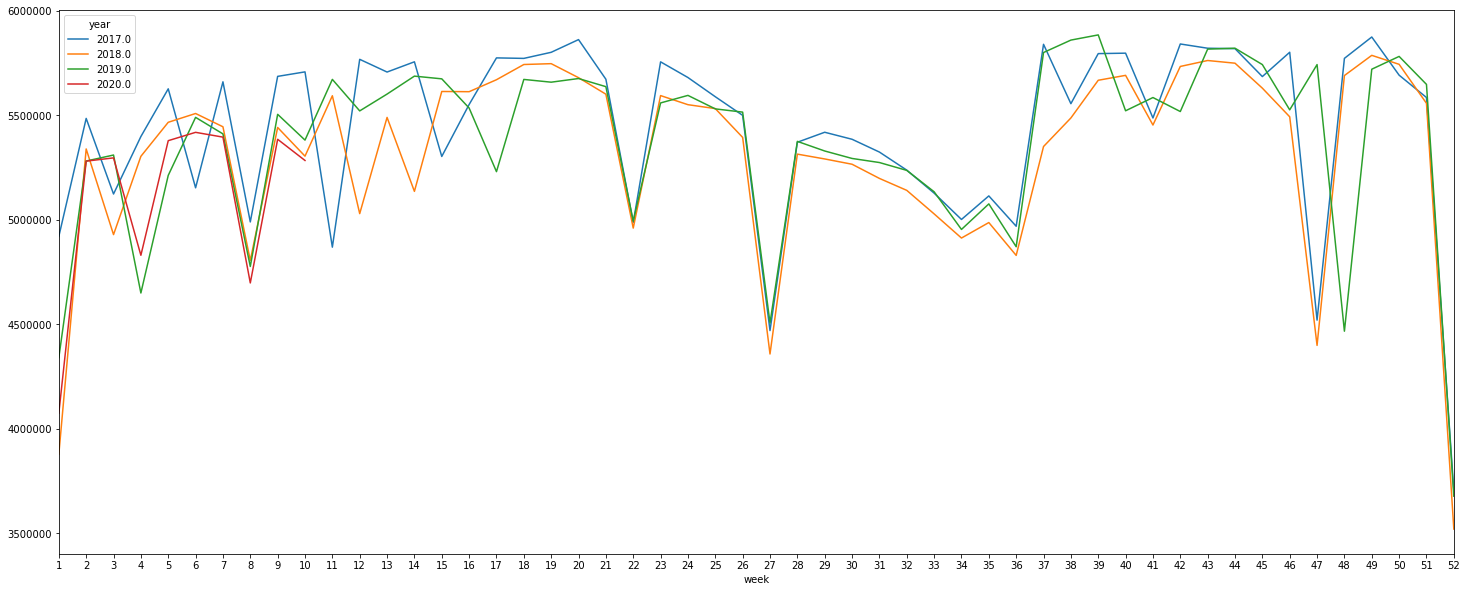

In [143]:
df = weekdays_df.pivot(index='week', columns='year', values='daily_entry_avg_weekdays').astype(float)
ax = df.plot(figsize=(25,10))
ax.xaxis.set_ticks([i for i in range(1, 53)])

In [141]:
daily_df = %sql $avg_daily_entry_query
daily_df = daily_df.DataFrame()

 * postgresql://postgres:***@db/mtatransit
830 rows affected.


In [ ]:
df = daily_df.pivot(index='day', columns='year', values='daily_entry').astype(float)
ax = df.plot(figsize=(25,10))
# ax.xaxis.set_ticks([i for i in range(1, 53)])

In [147]:
%%sql
SELECT 
    extract(year from recorded_date) as year,
    sum(entry_count) as annual_total
FROM 
    turnstile_transformed
where 
    entry_count < 2048
group by 
    year

 * postgresql://postgres:***@db/mtatransit
5 rows affected.


year,total_entry
2016.0,28980758
2017.0,1727153745
2018.0,1682506956
2019.0,1700290433
2020.0,293769083


In [148]:
# fare evasion is not the problem with mta ridership

In [150]:
%%sql
select count(distinct(station))
from turnstile_transformed

 * postgresql://postgres:***@db/mtatransit
1 rows affected.


count
358


In [187]:
station_mismatch_query = """
select distinct(station)
from turnstile_transformed
"""

In [188]:
dataframe = %sql $station_mismatch_query

 * postgresql://postgres:***@db/mtatransit
358 rows affected.


In [189]:
dataframe.DataFrame().to_csv('transformed.csv', index=False)